In [1]:
import gzip
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
from ctgan.synthesizers import CTGAN, TVAE
from sdv.evaluation import evaluate

In [2]:
class BenchmarkMLP(nn.Module):
    def __init__(self, input_dim=784, output_dim=10) -> None:
        super(BenchmarkMLP, self).__init__()
        num_layers = 1
        layer_dim = (100,)
        self.layers = []
        dim = input_dim
        for i in range(num_layers):
            self.layers.append(
                nn.Linear(dim, layer_dim[i])
            )
            self.layers.append(nn.ReLU())
            dim = layer_dim[i]
        self.layers.append(
            nn.Linear(dim, output_dim)
        )
        self.layers = nn.ModuleList(self.layers)
        self.layers.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)


    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        out = torch.squeeze(x, -1)
        return out

In [3]:
def train_model(
    train_X,
    train_y,
    valid_X,
    valid_y,
    test_X,
    test_y,
    input_dim=784,
    output_dim=10,
    num_epochs=10,
    batch_size=64,
    device="cuda",
    model_type="classification",
    verbose=True
):
    # Training
    train_len = train_X.shape[0]
    num_batches_per_epoch = train_len // batch_size
    if train_len % batch_size != 0:
        num_batches_per_epoch += 1
    if model_type == "classification":
        critetion = nn.CrossEntropyLoss()
    elif model_type == "regression":
        critetion = nn.MSELoss()
    else:
        print("Invalid model_type argument")
        return

    model = BenchmarkMLP(input_dim=input_dim, output_dim=output_dim).to(device)
    optimizer = optim.Adam(model.parameters())

    train_X = torch.Tensor(train_X).to(device)
    train_y = torch.Tensor(train_y).to(device)
    valid_X = torch.Tensor(valid_X).to(device)
    valid_y = torch.Tensor(valid_y).to(device)
    test_X = torch.Tensor(test_X).to(device)
    test_y = torch.Tensor(test_y).to(device)

    best_valid_score = -float("inf")
    best_model_weights = model.state_dict()
    for epoch in tqdm(range(num_epochs)):
        model.train()
        idx = 0
        epoch_loss = 0
        for _ in range(num_batches_per_epoch):
            input = train_X[idx : idx + batch_size]
            targets = train_y[idx : idx + batch_size]
            idx += batch_size
            output = model(input)
            loss = critetion(output, targets)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = epoch_loss / train_len

        model.eval()
        with torch.no_grad():
            output = model(valid_X)
            valid_loss = critetion(output, valid_y) / valid_y.shape[0]
            output = torch.argmax(output, -1)
            valid_score = f1_score(output.cpu(), valid_y.argmax(-1).cpu(), average="macro")
            if valid_score > best_valid_score:
                best_valid_score = valid_score
                best_model_weights = model.state_dict()

        if verbose or epoch % 25 == 0:
            print(f"Epoch: {epoch + 1}, Training Loss: {epoch_loss:.4f}, Valid Loss: {valid_loss:.8f}, Valid score: {valid_score:.4f}")

    print(f"Best validation score: {best_valid_score}")
    model.load_state_dict(best_model_weights)
    model.eval()
    with torch.no_grad():
        output = model(test_X)
        valid_loss = critetion(output, test_y) / test_y.shape[0]
        output = torch.argmax(output, -1)
        test_score = f1_score(output.cpu(), test_y.argmax(-1).cpu(), average="macro")
    
    return test_score

In [4]:
def load_mnist(path="dataset/mnist/"):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.

    https://mattpetersen.github.io/load-mnist-with-numpy
    Load from /home/USER/data/mnist or elsewhere; download if missing.
    """

    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        # return pixels.reshape(-1, 784).astype('float32') / 255
        return (pixels.reshape(-1, 784) != 0).astype(np.int8)

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    mnist_test_X = _images(os.path.join(path, files[2]))
    mnist_test_y = _labels(os.path.join(path, files[3]))

    mnist_train_X, mnist_valid_X, mnist_train_y, mnist_valid_y = train_test_split(train_images, train_labels, test_size=0.1, random_state=1, shuffle=True, stratify=train_labels.argmax(-1))

    return mnist_train_X, mnist_train_y, mnist_valid_X, mnist_valid_y, mnist_test_X, mnist_test_y

In [11]:
def load_fake_mnist(path="dataset/mnist/", synthesizer="ctgan", num_epochs=30, pretrained=""):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.

    https://mattpetersen.github.io/load-mnist-with-numpy
    Load from /home/USER/data/mnist or elsewhere; download if missing.
    """

    files = [
        'train-images-idx3-ubyte.gz',
        'train-labels-idx1-ubyte.gz',
    ]

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        # return pixels.reshape(-1, 784).astype('float32') / 255
        return (pixels.reshape(-1, 784) != 0).astype(np.int8)

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    train_data = np.concatenate((train_images, train_labels.argmax(-1)[:,None]), axis=1)
    if synthesizer == "ctgan":
        if pretrained:
            model = CTGAN.load(pretrained)
        else:
            model = CTGAN(batch_size=10**3, epochs=num_epochs)
    elif synthesizer == "tvae":
        if pretrained:
            model = TVAE.load(pretrained)
        else:
            model = TVAE(batch_size=10**3, epochs=num_epochs)
    else:
        print(f"Synthesizer {synthesizer} not defined!")
        return
    if not pretrained:
        model.fit(train_data, discrete_columns=list(range(train_data.shape[1])), epochs=num_epochs)
        # Training fake data synthesizer for MNIST takes a lot of time, save the model to reuse it
        now = datetime.datetime.now()
        current_time = now.strftime("%d-%m-%Y-%H-%M-%S")
        model.save(f"../models/mnist_{synthesizer}_{num_epochs}_epochs_{current_time}.pkl")
    fake_data = model.sample(train_data.shape[0])

    mnist_fake_train_X, mnist_fake_valid_X, mnist_fake_train_y, mnist_fake_valid_y = train_test_split(fake_data[:,:-1], np.eye(10)[fake_data[:,-1]], test_size=0.1, random_state=1, shuffle=True, stratify=fake_data[:,-1])

    return mnist_fake_train_X, mnist_fake_train_y, mnist_fake_valid_X, mnist_fake_valid_y

In [6]:
def load_credit(path="dataset/credit/"):
    credit_df = pd.read_csv(f"{path}creditcard.csv")
    credit_train_y = credit_df.pop("Class").to_numpy()
    credit_train_y = np.eye(2)[credit_train_y]
    credit_train_X = credit_df.to_numpy()
    credit_train_X, credit_test_X, credit_train_y, credit_test_y = train_test_split(credit_train_X, credit_train_y, test_size=20000, random_state=1, shuffle=True, stratify=credit_train_y)
    credit_train_X, credit_valid_X, credit_train_y, credit_valid_y = train_test_split(credit_train_X, credit_train_y, test_size=10000, random_state=1, shuffle=True, stratify=credit_train_y)

    return credit_train_X, credit_train_y, credit_valid_X, credit_valid_y, credit_test_X, credit_test_y

In [7]:
def load_adult(path="dataset/adult/"):
    adult_train_df = pd.read_csv(f"{path}adult.data", header=None)
    adult_test_df = pd.read_csv(f"{path}adult.test", header=None)
    columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income_50k"]
    cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income_50k"]
    adult_train_df.columns = columns
    adult_test_df.columns = columns
    adult_train_df = pd.get_dummies(adult_train_df, cat_columns)
    adult_test_df = pd.get_dummies(adult_test_df, cat_columns)
    # Remove extra . at the end in the test set
    adult_test_df["income_50k_ >50K"] = adult_test_df.pop("income_50k_ >50K.")
    adult_test_df["income_50k_ <=50K"] = adult_test_df.pop("income_50k_ <=50K.")
    # Add missing columns in test
    missing_columns = list(set(adult_train_df.columns) - set(adult_test_df.columns))
    for col_name in missing_columns:
        adult_test_df[col_name] = 0
    # Sort columns to ensure same ordering in train and test data frames
    adult_train_df = adult_train_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_test_df = adult_test_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_train_y = adult_train_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_train_X = adult_train_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_test_y = adult_test_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_test_X = adult_test_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_train_X, adult_valid_X, adult_train_y, adult_valid_y = train_test_split(adult_train_X, adult_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=adult_train_y.argmax(-1))

    return adult_train_X, adult_train_y, adult_valid_X, adult_valid_y, adult_test_X, adult_test_y 

In [8]:
def load_fake_adult(path="dataset/adult/", synthesizer="ctgan", num_epochs=50):
    adult_train_df = pd.read_csv(f"{path}adult.data", header=None)
    columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income_50k"]
    cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income_50k"]
    adult_train_df.columns = columns

    if synthesizer == "ctgan":
        model = CTGAN(epochs=num_epochs)
    elif synthesizer == "tvae":
        model = TVAE(epochs=num_epochs)
    else:
        print(f"Synthesizer {synthesizer} not defined!")
        return

    model.fit(adult_train_df, discrete_columns=cat_columns)
    fake_df = model.sample(adult_train_df.shape[0])
    score = evaluate(fake_df, adult_train_df)
    print(f"SDV fake data evaluation score: {score}")

    fake_df = pd.get_dummies(fake_df, cat_columns)
    adult_train_df = pd.get_dummies(adult_train_df, cat_columns)
    # Add missing columns in test
    missing_columns = list(set(adult_train_df.columns) - set(fake_df.columns))
    for col_name in missing_columns:
        fake_df[col_name] = 0
    # Sort columns to ensure same ordering in train and test data frames
    fake_df = fake_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_fake_train_X = fake_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_fake_train_y = fake_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_fake_train_X, adult_fake_valid_X, adult_fake_train_y, adult_fake_valid_y = train_test_split(
        adult_fake_train_X, adult_fake_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=adult_fake_train_y.argmax(-1)
    )

    return adult_fake_train_X, adult_fake_train_y, adult_fake_valid_X, adult_fake_valid_y

In [13]:
mnist_train_X, mnist_train_y, mnist_valid_X, mnist_valid_y, mnist_test_X, mnist_test_y = load_mnist("../dataset/mnist/")

test_score = train_model(
    mnist_train_X,
    mnist_train_y,
    mnist_valid_X,
    mnist_valid_y,
    mnist_test_X,
    mnist_test_y,
    input_dim=784,
    output_dim=10,
    batch_size=64,
    num_epochs=10,
    model_type="classification"
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for real mnist train data is: 0.96

In [8]:
credit_train_X, credit_train_y, credit_valid_X, credit_valid_y, credit_test_X, credit_test_y = load_credit("../dataset/credit/")

test_score = train_model(
    credit_train_X,
    credit_train_y,
    credit_valid_X,
    credit_valid_y,
    credit_test_X,
    credit_test_y,
    input_dim=30,
    output_dim=2,
    batch_size=256,
    num_epochs=20,
    model_type="classification"
)
print(f"Test score: {test_score}")

In [24]:
adult_train_X, adult_train_y, adult_valid_X, adult_valid_y, adult_test_X, adult_test_y = load_adult("../dataset/adult/")

test_score = train_model(
    adult_train_X,
    adult_train_y,
    adult_valid_X,
    adult_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=128,
    num_epochs=50,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for real adult train data is: 0.75

### MNIST

### CTGAN

In [15]:
mnist_fake_train_X, mnist_fake_train_y, mnist_fake_valid_X, mnist_fake_valid_y = load_fake_mnist("../dataset/mnist/", synthesizer="ctgan", num_epochs=30)

100%|██████████| 30/30 [16:13<00:00, 32.45s/it]


5


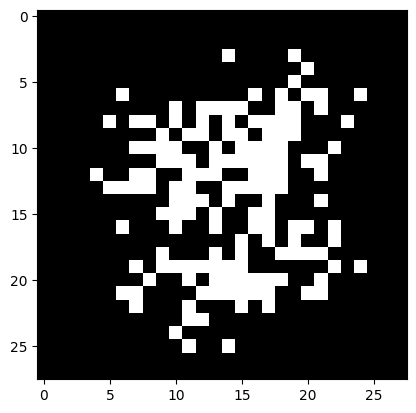

In [56]:
idx = np.random.randint(1, mnist_fake_train_X.shape[0])
plt.imshow(mnist_fake_train_X[idx,:].reshape(28, 28), cmap="gray")
print(mnist_fake_train_y[idx].argmax(-1))

test_score = train_model(
    mnist_fake_train_X,
    mnist_fake_train_y,
    mnist_fake_valid_X,
    mnist_fake_valid_y,
    mnist_test_X,
    mnist_test_y,
    input_dim=784,
    output_dim=10,
    batch_size=64,
    num_epochs=10,
    model_type="classification"
)
print(f"Test score: {test_score}")

#### TODO: Train CTGAN for 200 epochs on mnist
#### Best test (real data) F1 macro score for fake mnist CTGAN (30 epochs) train data is: 0.06

### TVAE

### TVAE consumes 100% of my RAM on MNIST dataset after 10 epochs due to an memory leak
### TODO: Test if this happens on other systems

tvae = TVAE(batch_size=10**3, epochs=30)
tvae.fit(data, discrete_columns=list(range(data.shape[1])))

fake = tvae.sample(1)
plt.imshow(fake[0][:-1].reshape(28, 28), cmap="gray")
print(fake[0][-1])

## Adult dataset

#### CTGAN

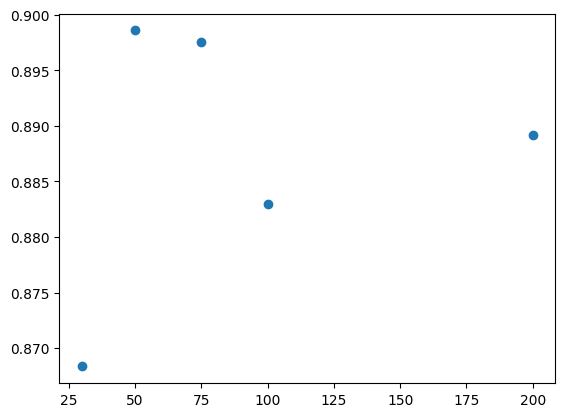

In [12]:
plt.scatter(x=results.keys(), y=results.values())

##### 50 epochs produced the best SDV fake data evaluation score for CTGAN, we will use 50 epochs for VAE as well

### TVAE

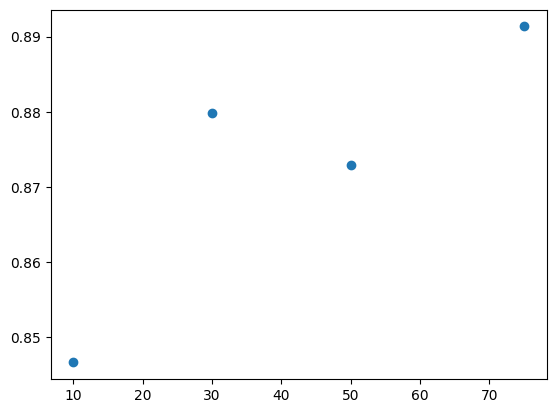

In [27]:
# VAE is unable to train for >= 100 epochs
vae_results
plt.scatter(x=vae_results.keys(), y=vae_results.values())

### ML efficacy of CTGAN on Adult dataset

In [30]:
adult_fake_train_X, adult_fake_train_y, adult_fake_valid_X, adult_fake_valid_y = load_fake_adult(path="../dataset/adult/", synthesizer="ctgan")

100%|██████████| 50/50 [01:32<00:00,  1.84s/it]


SDV fake data evaluation score: 0.8906754803308501


test_score = train_model(
    adult_fake_train_X,
    adult_fake_train_y,
    adult_fake_valid_X,
    adult_fake_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=128,
    num_epochs=50,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for fake adult CTGAN train data is: 0.70

### ML efficacy of TVAE on Adult dataset

In [32]:
adult_fake_train_X, adult_fake_train_y, adult_fake_valid_X, adult_fake_valid_y = load_fake_adult(path="../dataset/adult/", synthesizer="tvae")

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


SDV fake data evaluation score: 0.8878818538755011


test_score = train_model(
    adult_fake_train_X,
    adult_fake_train_y,
    adult_fake_valid_X,
    adult_fake_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=128,
    num_epochs=50,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for fake adult TVAE train data is: 0.70